In [34]:
import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torchvision import transforms,datasets
from transformers import ViTForImageClassification,ViTFeatureExtractor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report 
import pandas as pd

In [25]:
folderPath = "../../../Data/images/"
MODEL_PATH = "vit_emotion_pytorch.pth"
NUM_CLASSES = 7
BATCH_SIZE = 32
IMG_SIZE = 224
TEST_DIR=folderPath+"validation"
DEVICE =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/Users/himasha/Downloads/Emotion_detector-main/.venv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [27]:
def convert_to_rgb(image):
    return image.convert("RGB")

test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.Lambda(convert_to_rgb),
        transforms.ToTensor(),
        transforms.Normalize(mean=extractor.image_mean, std=extractor.image_std)
    ])

In [28]:
test_dataset= datasets.ImageFolder(root=TEST_DIR,transform=test_transform)
test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE,shuffle=False,num_workers=0)

class_names = test_dataset.classes
print("Class names:", class_names)

Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [29]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=NUM_CLASSES
)

model.load_state_dict(torch.load(MODEL_PATH,map_location=DEVICE))
model.to(DEVICE)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [30]:
model.eval()
all_preds = []
all_labels = []
running_loss = 0.0
correct_predictions = 0
total_samples = 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating", leave=True)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        loop.set_postfix(
            loss=running_loss /(loop.n + 1),
            acc = correct_predictions/total_samples
            )
        

Evaluating: 100%|██████████| 221/221 [07:05<00:00,  1.93s/it, acc=0.657, loss=1.17]


In [31]:
final_accuracy = correct_predictions / total_samples
final_loss = running_loss / len(test_loader)
print("Test Results")
print(f"Average Loss: {final_loss:.4f} ")
print(f"Accuracy: {final_accuracy * 100:.2f}%")

Test Results
Average Loss: 1.1675 
Accuracy: 65.72%


In [32]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names,digits=4))

Classification Report:
              precision    recall  f1-score   support

       angry     0.6405    0.5531    0.5936       960
     disgust     0.7424    0.4414    0.5537       111
        fear     0.5544    0.4352    0.4876      1018
       happy     0.7656    0.9233    0.8371      1825
     neutral     0.5285    0.7475    0.6192      1216
         sad     0.6319    0.4100    0.4973      1139
    surprise     0.7865    0.7026    0.7422       797

    accuracy                         0.6572      7066
   macro avg     0.6643    0.6019    0.6187      7066
weighted avg     0.6578    0.6572    0.6462      7066



Confusion Matrix:


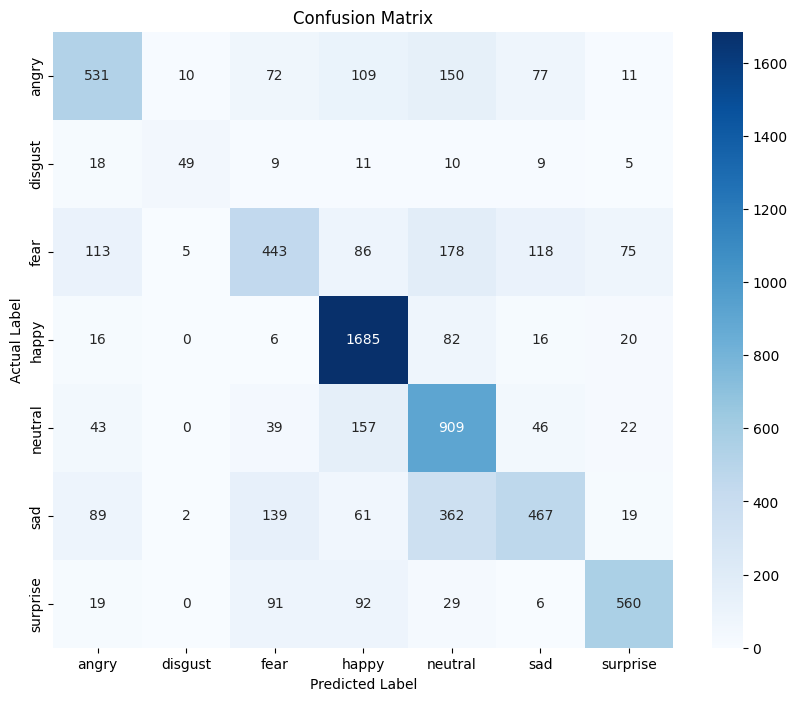

In [33]:
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

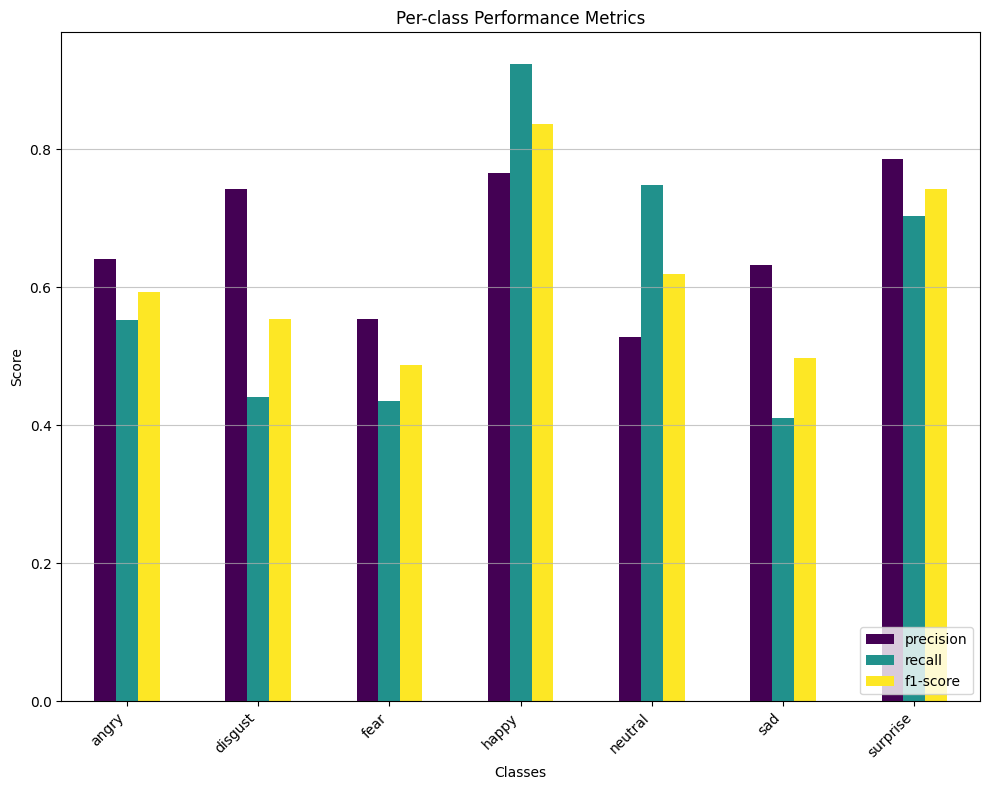

In [36]:
report = classification_report(all_labels, all_preds, target_names=class_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_classes = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])
df_plot = df_classes[['precision', 'recall', 'f1-score']]
df_plot.plot(kind='bar',figsize=(10, 8),colormap='viridis')

plt.title('Per-class Performance Metrics')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45,ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y',alpha=0.7)
plt.tight_layout()
plt.show()
